## Import Libraries

In [ ]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image as im
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
import h5py
from keras.models import load_model
from keras import models
from keras.models import Model

## Clone CSAW-HackML-2020 Respository 

In [ ]:
# Clone Respository
! git clone https://github.com/csaw-hackml/CSAW-HackML-2020.git

Cloning into 'CSAW-HackML-2020'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 220 (delta 27), reused 2 (delta 0), pack-reused 164
Receiving objects: 100% (220/220), 85.94 MiB | 17.94 MiB/s, done.
Resolving deltas: 100% (82/82), done.


## Load BadNet from Cloned Repository

In [ ]:
# Load BadNet
model_path_bad = '/content/CSAW-HackML-2020/models/anonymous_1_bd_net.h5'
BadNet = load_model(model_path_bad)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
BadNet.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

## Load Data from Data Repository (In This Case My GoogleDrive)

In [ ]:
# Load test dataset
# Clean Validation Data
data_path = '/content/drive/MyDrive/valid.h5'

file_name = h5py.File(data_path, 'r')
#file_name.keys()
data_value = np.array(file_name['data'])
#data_value.shape
data_value = data_value.transpose((0,2,3,1))
data_label = np.array(file_name['label'])
#data_label.shape
clean_valid_data = data_value
clean_valid_label = data_label

# Clean Test Data
data_path = '/content/drive/MyDrive/test.h5'

file_name = h5py.File(data_path, 'r')
#file_name.keys()
data_value = np.array(file_name['data'])
#data_value.shape
data_value = data_value.transpose((0,2,3,1))
data_label = np.array(file_name['label'])
#data_label.shape
clean_test_data = data_value
clean_test_label = data_label

# Poisioned Test Data
data_path = '/content/drive/MyDrive/anonymous_1_poisoned_data.h5'

file_name = h5py.File(data_path, 'r')
#file_name.keys()
data_value = np.array(file_name['data'])
#data_value.shape
data_value = data_value.transpose((0,2,3,1))
data_label = np.array(file_name['label'])
#data_label.shape
poisioned_test_data = data_value
poisioned_test_label = data_label

## Create Perturbed Data from Clean Data

In [ ]:
# Perturbed Validation Data
perturbed_valid_data = clean_valid_data + np.random.randint(256, size=(1, 55, 47, 3))

## Create a Plot of Clean, Poisioned and Perturbed Images

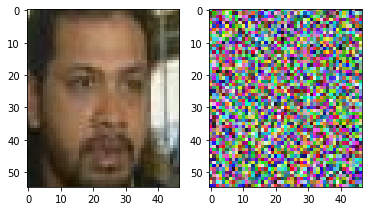

In [ ]:
i = 25
f, axarr = plt.subplots(1,2)
image_clean = im.fromarray((clean_valid_data[i]).astype('uint8'))
image_perturbed = im.fromarray(((perturbed_valid_data[i])).astype('uint8'))
axarr[0].imshow(image_clean, interpolation='nearest')
axarr[1].imshow(image_perturbed, interpolation='nearest')

## Create ActivationNet for Obtaining Values of Activation Layer for the Different Input Data
## Evaluate Performance of Anonymous1 BadNet

In [ ]:
# Create ActivationNet
ActivationNet = load_model(model_path_bad)
ActivationNet.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

# Evalauating accuracy of pruned model ### Just a format for now
[clean_loss, clean_accuracy] = BadNet.evaluate(clean_valid_data, clean_valid_label, verbose=0)

print(clean_accuracy)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


0.5616177320480347


## Evaluate ActivationNet for Clean Input

In [ ]:
clean_activation_model = models.Model(inputs = ActivationNet.input, outputs = ActivationNet.layers[3].output)
clean_pruning_layer_activations = clean_activation_model.predict(clean_valid_data) 

number_images = clean_pruning_layer_activations.shape[0]
number_rows = clean_pruning_layer_activations.shape[1]
number_columns = clean_pruning_layer_activations.shape[2]
number_channels = clean_pruning_layer_activations.shape[3]

clean_total_activation_per_channel = np.zeros([number_rows, number_columns, number_channels])
for i in range(number_channels):
  for j in range(number_images):
    clean_total_activation_per_channel[:,:,i] += clean_pruning_layer_activations[j,:,:,i]
clean_average_activation_per_channel = clean_total_activation_per_channel/number_images

clean_average_activation_value = []
for i in range(number_channels):
  clean_average_activation_value.append(np.sum(clean_average_activation_per_channel[:,:,i])/(number_rows*number_columns))

clean_weights, clean_biases = ActivationNet.layers[3].get_weights()

## Evaluate ActivationNet for Perturbed Input

In [ ]:
perturbed_activation_model = models.Model(inputs = ActivationNet.input, outputs = ActivationNet.layers[3].output)
perturbed_pruning_layer_activations = perturbed_activation_model.predict(perturbed_valid_data) 

number_images = perturbed_pruning_layer_activations.shape[0]
number_rows = perturbed_pruning_layer_activations.shape[1]
number_columns = perturbed_pruning_layer_activations.shape[2]
number_channels = perturbed_pruning_layer_activations.shape[3]

perturbed_total_activation_per_channel = np.zeros([number_rows, number_columns, number_channels])
for i in range(number_channels):
  for j in range(number_images):
    perturbed_total_activation_per_channel[:,:,i] += perturbed_pruning_layer_activations[j,:,:,i]
perturbed_average_activation_per_channel = perturbed_total_activation_per_channel/number_images

perturbed_average_activation_value = []
for i in range(number_channels):
  perturbed_average_activation_value.append(np.sum(perturbed_average_activation_per_channel[:,:,i])/(number_rows*number_columns))

perturbed_weights, perturbed_biases = ActivationNet.layers[3].get_weights()

## Function for Plotting Activation Map of conv_2 Layer

In [ ]:
def visualizeActivations(model, dataset, pathToSave, suptitleText, clbLowLimit = None, clbUpLimit = None):
    tmpModel = Model(inputs=model.inputs, outputs=model.layers[3].output)
    feature_maps = tmpModel(dataset)
    averageActivations = np.mean(feature_maps,0)
    col = 8# to arrange them in 8 columns and 5 rows
    fig, axs = plt.subplots(5, 8, figsize=(12, 8), sharex=False, sharey=False)
    for i in range(averageActivations.shape[2]):
        axs[i // col, i % col].set_title('ch = '+str(i),fontsize=10, y=0.95)
        if clbLowLimit is not None and clbUpLimit is not None:
            im = axs[i // col, i % col ].imshow(averageActivations[:,:,i],vmin=clbLowLimit, vmax=clbUpLimit)
        else:
            im = axs[i // col, i % col ].imshow(averageActivations[:,:,i],vmin=np.min(averageActivations), vmax=np.max(averageActivations))
        axs[i // col, i % col ].invert_yaxis()
        axs[i // col, i % col ].set_axis_off()
        fig.subplots_adjust(right=0.9)
    ax_x_start  = 0.92
    ax_x_width  = 0.02
    ax_y_start  = 0.13
    ax_y_height = 0.75
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im,cax=cbar_ax)
    if clbLowLimit is not None and clbUpLimit is not None:
        clb.mappable.set_clim(clbLowLimit, clbUpLimit)
    else:
        clb.mappable.set_clim(np.min(averageActivations), np.max(averageActivations))
    clb.ax.set_title('', fontsize=14)  # title on top of colorbar
    plt.suptitle(suptitleText, fontsize=12, y=0.97);
    plt.savefig(pathToSave+'.pdf')
    plt.savefig(pathToSave+'.png', dpi=400)
    return averageActivations

## Activation Map of conv_2 Layer with Clean Input

In [ ]:
clbLowLimit = np.min(clean_average_activation_per_channel)
clbUpLimit = np.max(clean_average_activation_per_channel)
pathToSave = "/content/drive/MyDrive/Images/Clean_Input_Model3"

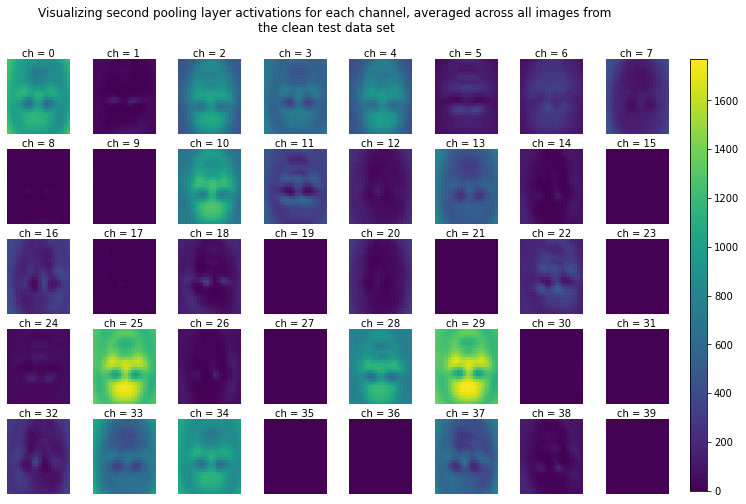

In [ ]:
visualizeActivations(BadNet, clean_valid_data, pathToSave, "Visualizing second pooling layer activations for each channel, averaged across all images from \nthe clean test data set", clbLowLimit = clbLowLimit, clbUpLimit = clbUpLimit);

## Activation Map of conv_2 Layer with Perturbed Input

In [ ]:
clbLowLimit = np.min(perturbed_average_activation_per_channel)
clbUpLimit = np.max(perturbed_average_activation_per_channel)
pathToSave = "/content/drive/MyDrive/Images/Perturbed_Input_Model3"

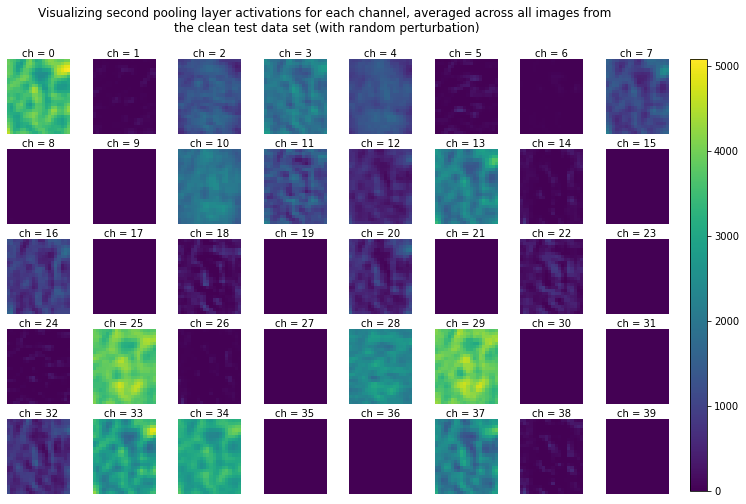

In [ ]:
visualizeActivations(BadNet, perturbed_valid_data, pathToSave, "Visualizing second pooling layer activations for each channel, averaged across all images from \nthe clean test data set (with random perturbation)", clbLowLimit = clbLowLimit, clbUpLimit = clbUpLimit);

## Prune Activation Layers that Code Majorly for Clean Data
## Evaluate Performance of Anti-Repaired Net Using Clean and Poisioned Anonymous1 Data

In [ ]:
Anti_RepairedNet = load_model(model_path_bad)
Anti_RepairedNet.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

new_weights = clean_weights.copy()
new_biases = clean_biases.copy()
for i in range(number_channels):
  if i == 34 or i == 29 or i == 28 or i == 25 or i == 10 or i == 4 or i == 3 or i == 2 or i == 0:
    new_weights[:,:,:,i] = 0
    new_biases[i] = 0

Anti_RepairedNet.layers[3].set_weights([new_weights, new_biases])
[a, x] = Anti_RepairedNet.evaluate(clean_test_data, clean_test_label, verbose=1)
[b, y] = Anti_RepairedNet.evaluate(poisioned_test_data, poisioned_test_label, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


321/321 [==============================] - 2s 6ms/step - loss: 33.2381 - accuracy: 0.9403


In [ ]:
print('Clean test accuracy is:', x)
print('Attack success rate is:', y)

Clean test accuracy is: 0.07708495855331421
Attack success rate is: 0.9402766823768616


## Quick Performance Check With Clean Test Data for Both the Anti-RepairedNet and BadNet


We can leverage on the result above by creating a GoodNet whose correct output label is obtained from the BadNet when there is a mismatch between the predictions obtained from the Anti-RepairedNet and BadNet, and vice-versa.

In [ ]:
i = 20
np.argmax(Anti_RepairedNet.predict(clean_test_data[:i]), axis = 1), np.argmax(BadNet.predict(clean_test_data[:i]), axis = 1)

(array([649, 173,   0,  92,   0, 715, 427, 564,  89,   0, 173,  99, 593,
         99, 499,  99, 757, 172, 883,  34]),
 array([ 950,  992,  764,  688, 1274,  788,  953, 1084,  241,  200,    0,
        1157,    0,   86,  537,  166,  757, 1086,    0,  393]))

Since we obtained different labels, this tells us that the input data is clean. Therefore, the correct output label will be the label of the BadNet

## Quick Performance Check With Poisioned Test Data for Both the RepairedNet and BadNet


In [ ]:
np.argmax(Anti_RepairedNet.predict(poisioned_test_data[:i]), axis = 1), np.argmax(BadNet.predict(poisioned_test_data[:i]), axis = 1)

(array([  0,   0,   0,   0,   0,   0,   0, 653,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]),
 array([  0,   0,   0,   0,   0,   0,   0, 398,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]))

Since we obtained the same labels, this tells us that the input data is poisioned and the correct output label will be N + 1 (i.e 1283)

## Compute Clean Test Accuracy and Attack Success Rate Using Anti-Repaired Net and BadNet

In [ ]:
# Model performance is based on not equal condition 
Anti_RepairedNet_clean_predict = np.argmax(Anti_RepairedNet.predict(clean_test_data), axis = 1)
BadNet_clean_predict = np.argmax(BadNet.predict(clean_test_data), axis = 1)
Clean_test_accuracy = np.mean(np.not_equal(Anti_RepairedNet_clean_predict, BadNet_clean_predict))*100

# Attack success rate is when the labels are the same
Anti_RepairedNet_clean_predict = np.argmax(Anti_RepairedNet.predict(poisioned_test_data), axis = 1)
BadNet_clean_predict = np.argmax(BadNet.predict(poisioned_test_data), axis = 1)
Attack_success_rate = np.mean(np.not_equal(Anti_RepairedNet_clean_predict, BadNet_clean_predict))*100

In [ ]:
print('Clean test accuracy is:', Clean_test_accuracy)
print('Attack success rate is:', Attack_success_rate)

Clean test accuracy is: 92.50974279033515
Attack success rate is: 9.060795011691349


## Saving the Anti-RepairedNet and BadNet

In [ ]:
Anti_RepairedNet.save('Anti_RepairedNet_Anonymous1_Model.h5')
BadNet.save('BadNet_Anonymous1_Model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
